# Disclaimer: 
This tutorial is by no means meant to be complete in presenting the complex topic of Umbrella sampling (US) simulations and their analysis. It is meant to provide an introduction and some initial guidelines on how to perform such simulations and analyse them.

# GROMACS Umbrella Sampling Tutorial
This tutorial is aimed at providing the information on how to run
and analyse Umbrella Sampling (US) simulations in GROMACS. It is based on
both the tutorial material available from Justin Lemkul at
http://www.bevanlab.biochem.vt.edu/Pages/Personal/justin/gmx-tutorials/umbrella/index.html
and Wes Barnett at https://wbarnett.us/tutorials/5_umbrella/.
Umbrella Sampling is a method aimed to force systems to explore states in phase space
that are unaccessible during normal Molecular Dynamics (MD) simulations,
by applying a bias potential to  a possition on a given reaction coordinate.

*Author: Paul Bauer
Email: pbauer@kth.se*

# Basic Information
All steps in the tutorial can be performed through the notebook interface here, or by
running the individual python scripts that are located in the subfolders with the notebook.
The scripts will by default just prepare the run input files
(so that it can be done on any machine), but can also be invoked with additional
options to perform the actual simulations that provided the data used in the final analysis.



## System information
We will be simulating a system of two pyrimidine molecules in water
and will try to estimate the Potential of Mean Force (PMF) for
moving those two molecules together from infinite distance.
<img src="pyrimidine.png" alt="pyr" style="height: 300px;"/>


## File location and availability
The files for the pyrimidine topology are available from the
http://virtualchemistry.org/ database on organic molecules.
They can be downloaded here for GROMACS 
http://virtualchemistry.org/molecule.php?filename=pyrimidine.zmat
For the tutorial, the files have already been downloaded and prepared
for running, but if you want to try you can prepare a different small
molecule yourself!

# Tutorial directory structure
The tutorial is based on several folders that are included in the repository
and is automatically set up when the material is downloaded.


All the files to perform the
simulation and run the analysis are present.
The following directories are present:
* 0-files
  * Containing all the unmodified files used for setting up the simulation
  * These include an empty topology with just water in a box, as well
    as the topology files for pyrimidine
* 1-topology
  * Containing inputs to generate the basic topology with 
    two pyrimidine molecules by using gmx insert-molecules
  * Also the folders for the steps to change the box size, solvation
    and adding of ions 
* 2-umbrella
  * Contains a set of scripts to run the actual simulations
    for each window of the reaction coordinate. 
  * This is meant to be used on a cluster instead, and running the jobs is not
    part of this tutorial
* 3-analysis
  * Folder with data from simulations performed previously that can
    be analysed to obtain the PMF of the simulation

# Setting up the environment
First, some basic python libraries are loaded, as well as a set of custom helper functions that
wrap the calls to the GROMACS binaries

In [1]:
import os
import shutil
import subprocess
import math
import numpy as np
import matplotlib.pyplot as plt

We start by importing all our helper functions

In [2]:
from functions import *

If you want to have a look at the directory structure, you can do so through either
a local shell or here with the command below

In [3]:
listdirectory('.')

Umbrella Sampling Tutorial.ipynb
0-files
2-umbrella
functions.py
1-topology
pyrimidine.png
functions.pyc
.ipynb_checkpoints
.gitignore
3-analysis


Followed by preparation of the actual simulations by checking that we have a GROMACS
installation in our $PATH to make sure we can run the program

In [4]:
if not which('gmx'):
    print "%s not found in $PATH" % 'gmx'

Followed by setting the global path name

In [5]:
globalpath = os.getcwd()
print globalpath

/data/us-bitbucket/tutorials/pyrimidine-umbrella-sampling


If the script tells you that gmx (the GROMACS wrapper binary)
is not in the $PATH, close the notebook, source the used GROMACS
installation and try again

# Setting up input files and geometry
We will enter the subdirectory to perform the system setup and generate the
topology, based on the global path set up before.

You can also check yourself in the shell that you are in the correct directory now if needed.

In [6]:
os.chdir(globalpath+'/1-topology/insert')
print os.getcwd()

/data/us-bitbucket/tutorials/pyrimidine-umbrella-sampling/1-topology/insert


## Prepare initial topology by inserting two molecules of pyrimidine into an empty box
We are using the python api to execute GROMACS wrapper binary with the arguments to run
the `insert-molecules` module that allows us to place two molecules of or organic molecule
in the simulation box. *As a note, there are other ways to do this as well*

To use the api, we need to build a list of all the individual strings in the command.
We want to insert (option `-ci`) the molecule found in the `pyrimidine_T298.15_gas.pdb` file.
We want two (`nmol 2`) molecules in the final structure, with a maximum box size of 2 nm in each direction
`-box 2 2 2`. This is needed because in general the distance for US sampling coordiantes can not be larger then
half of the box size. The final file written will be `pyrimidine_insert.gro`.

The call to `subprocess.check_call` will execute the binary independently from the notebook
and also tells you what goes wrong if the execution fails. An alternative would be the use
of the exclamation mark before the command being executed. For all future commands, we have
provided first a string of the command, that is later split into the list needed for the
invocation.

In [7]:
command = "gmx insert-molecules -ci pyrimidine_T298.15_gas.pdb -box 2 2 2 -nmol 2 -o pyrimidine_insert.gro"
commandlist=command.split()
print command
print commandlist

gmx insert-molecules -ci pyrimidine_T298.15_gas.pdb -box 2 2 2 -nmol 2 -o pyrimidine_insert.gro
['gmx', 'insert-molecules', '-ci', 'pyrimidine_T298.15_gas.pdb', '-box', '2', '2', '2', '-nmol', '2', '-o', 'pyrimidine_insert.gro']


In [8]:
subprocess.check_call(commandlist)

0

This will give us the new structure file with the two molecules randomly oriented
we can copy this file to the next directory to change the size of the 
simulation box so that we can later calculate the full PMF.

You can check that the file is present with the next command
that is imported from the `functions.py` file

In [9]:
listdirectory('.')

pyrimidine_insert.gro
pyrimidine_T298.15_gas.pdb


To move the file to the next directory, we again use the python api to declare the files to copy
and the destination based on the absolute path defined before.

In [10]:
structurefile = "pyrimidine_insert.gro"
nextdir = globalpath+"/1-topology/box"
shutil.copy2(structurefile,nextdir)

Now move to the next directory and again check that the correct files are present

In [11]:
os.chdir(nextdir)
print os.getcwd()
listdirectory('.')

/data/us-bitbucket/tutorials/pyrimidine-umbrella-sampling/1-topology/box
pyrimidine_insert.gro
.empty


## Changing box dimensions
In this directory, we change the box to be 5 nm in each direction to allow us to sample a PMF
for a distance of up to 2.5 nm between the two molecules. We use `gmx editconf` to change the box size
to 5 nm in each direction `box 5 5 5` and write a new output file `pyrimidine_largebox.gro`

In [12]:
command = "gmx editconf -f pyrimidine_insert.gro -o pyrimidine_largebox.gro -box 5 5 5"
commandlist=command.split()
print command
print commandlist

gmx editconf -f pyrimidine_insert.gro -o pyrimidine_largebox.gro -box 5 5 5
['gmx', 'editconf', '-f', 'pyrimidine_insert.gro', '-o', 'pyrimidine_largebox.gro', '-box', '5', '5', '5']


In [13]:
subprocess.check_call(commandlist)

0

## Topology preparation
We have also prepared a topology file, topol.top, that can be used for the later steps.

The script `writetopfile` from the `functions.py` file generates it in the current directory
with the information needed to continue later.

The topology file contains only the basic information for using two molecules
of pyrimidine, as well as the location of the files needed to run the remaining steps.

In [14]:
writetopfile("topol.top", globalpath)

We copy those files to the next directory to solvate the structure before the minimzation
the file will be written with the information about its position, so it can properly include
the correct forcefield that contains the information for pyrimidine.

This time we have to copy several files, so we need to declare a list of all files,
that are then copied in a loop.

In [15]:
copyfiles = ["pyrimidine_largebox.gro", "topol.top"]
nextdir = globalpath+"/1-topology/solvate"

for files in copyfiles:
    shutil.copy2(files,nextdir)

Now move to the next directory and again check that the correct files are present

In [16]:
os.chdir(nextdir)
print os.getcwd()
listdirectory('.')

/data/us-bitbucket/tutorials/pyrimidine-umbrella-sampling/1-topology/solvate
pyrimidine_largebox.gro
topol.top
.empty


## Basic solvation
For the next step, we solvate the system with tip4p water using `gmx solvate`, again wrapped in the
python api call.

In [17]:
command = "gmx solvate -cp pyrimidine_largebox.gro -cs tip4p -p topol.top -o solv.gro"
commandlist=command.split()
print command
print commandlist

gmx solvate -cp pyrimidine_largebox.gro -cs tip4p -p topol.top -o solv.gro
['gmx', 'solvate', '-cp', 'pyrimidine_largebox.gro', '-cs', 'tip4p', '-p', 'topol.top', '-o', 'solv.gro']


In [18]:
subprocess.check_call(commandlist)

0

Again, the files are copied and we move to the next directory.

In [19]:
copyfiles = ["solv.gro", "topol.top"]
nextdir = globalpath+"/1-topology/ion"
for files in copyfiles:
    shutil.copy2(files,nextdir)

In [20]:
os.chdir(nextdir)
print os.getcwd()
listdirectory('.')

/data/us-bitbucket/tutorials/pyrimidine-umbrella-sampling/1-topology/ion
system.ndx
ions.mdp
solv.gro
topol.top
index.ndx


## Add ions and prepare final structure
To have a final structure, we add ions to our initial system and prepare it for
equilibration, by using the standard GROMACS commands for `gmx grompp`.

In [21]:
command = "gmx grompp -f ions -c solv -p topol -o ions"
commandlist=command.split()
print command
print commandlist

gmx grompp -f ions -c solv -p topol -o ions
['gmx', 'grompp', '-f', 'ions', '-c', 'solv', '-p', 'topol', '-o', 'ions']


In [22]:
subprocess.check_call(commandlist)

0

Adding ions follows by using `gmx genion`. Note that we have to pass the
selection for the solvent atom group (here 4) to the program. In python, we
can use the `os.pipe()` command to send the selection string to the program,
and having the `check_call` function read it on standard input.
On the command line, you would be using something like
`echo 4 | gmx genion ...`.

First, we generate the pipe with the selection.

In [23]:
read, write = os.pipe()
os.write(write, "4")
os.close(write)

In [24]:
command = "gmx genion -s ions -nname CL -pname NA -neutral -conc 0.15 -o ions -p topol.top"
commandlist=command.split()
print command
print commandlist

gmx genion -s ions -nname CL -pname NA -neutral -conc 0.15 -o ions -p topol.top
['gmx', 'genion', '-s', 'ions', '-nname', 'CL', '-pname', 'NA', '-neutral', '-conc', '0.15', '-o', 'ions', '-p', 'topol.top']


In [25]:
subprocess.check_call(commandlist, stdin=read)

0

## This concludes the topology preparation section.

Next, we will copy the final files to the run directory and prepare the
index file needed to run the simulation with the different pull groups.

There are multiple ways to generate index files, and you have seen how to use
`gmx make_ndx` during the previous lecture. Here, we will use `gmx select` to generate
a file containing the groups for our two pyrimidine molecules, and will merge
those groups with a prepared files containing the remaining system.

We have to manually add the selection string to the command, because it can get
misformatted by python.

In [26]:
command = "gmx select -s ions.tpr -on mols -select"
commandlist=command.split()
print command
commandlist.append("mol 1; mol 2")
print commandlist

gmx select -s ions.tpr -on mols -select
['gmx', 'select', '-s', 'ions.tpr', '-on', 'mols', '-select', 'mol 1; mol 2']


In [27]:
subprocess.check_call(commandlist)

0

We concatenate the two files for the base system `system.ndx` and for the
pyrimidine m.lecules `mols.ndx`-

In [28]:
filenames = ['system.ndx', 'mols.ndx']
with open('index.ndx', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            outfile.write(infile.read())

We now have all the files needed to run the simulations, and can proceed
to setting up the input files for running GROMACS.

This will again be done in a new directory, so we move there.

In [29]:
copyfiles = ["ions.gro", "topol.top", "index.ndx"]
nextdir = globalpath+"/2-umbrella"
for files in copyfiles:
    shutil.copy2(files,nextdir)

In [30]:
os.chdir(nextdir)
print os.getcwd()
listdirectory('.')

/data/us-bitbucket/tutorials/pyrimidine-umbrella-sampling/2-umbrella
topol.top
.empty
ions.gro
index.ndx


# Running Umbrella Sampling in GROMACS

In this directory, we will run the script that performs the simulation
of the individual umbrella windows. As each of those simulations might take several hours,
we will only prepare a set of example simulations and not actual run all of them.

The python command used to prepare them can also be used to run them, but this should
be done instead on a dedicated system with the necessary computing capabilities.

In preparation for running the simulation, we need to provide the directory we are in.

In [31]:
inputdir = globalpath+"/2-umbrella"

## The `umbrella` function

The tutorial comes with a python wrapper function that is able to set up and run
the simulations of all US windows, while also setting up the directories and `mdp`
input files. The function requires several arguments that are explained below:

* Number of umbrella sampling windows.
* Boolean flag that decides on actual running simulation or not.
* Maximum COM distance between molecules, needs to be less than half of box length.
* Minimum distance, should be physical.
* Path to input directory to look up files.
* Name of first molecule to be used for COM position
* Name of second molecule

`umbrella` will call several other functions that create the input files and
run the GROMACS binaries that will not be explained in detail.

In [32]:
umbrella(25,False,2.5,0.05,inputdir, group1name = "mol_1", group2name = "mol_2")

After running the script, you will see that it generated a number of directories
that contain the run input files for running the simulations.

First, lets check the new directories:

In [33]:
listdirectory('.')

run-1
run-6
run-9
run-0
run-24
run-18
run-8
run-22
run-20
run-4
run-19
run-3
run-21
run-12
topol.top
.empty
run-13
run-11
run-23
run-10
run-17
run-15
ions.gro
run-14
run-5
run-16
run-2
run-7
index.ndx


You can also check the contents for one of the generated directories:

In [34]:
listdirectory('./run-1')

eql.1.mdp
min2.1.mdp
prd.1.mdp
min.1.mdp
topol.top
eql2.1.mdp
ions.gro
index.ndx


Print the contents of the mdp files for one run

In [35]:
with open("run-1/prd.1.mdp") as f:
    for line in f:
        print line





integrator               = md

dt                       = 0.002     ; 2 fs

nsteps                   = 2500000   ; 5.0 ns



nstenergy                = 5000

nstlog                   = 5000

nstxout-compressed       = 2000



continuation             = yes

constraint-algorithm     = lincs

constraints              = h-bonds



cutoff-scheme            = Verlet



coulombtype              = PME

rcoulomb                 = 1.0



vdwtype                  = Cut-off

rvdw                     = 1.0

DispCorr                 = EnerPres



tcoupl                   = Nose-Hoover

tc-grps                  = System

tau-t                    = 2.0

ref-t                    = 298.15

nhchainlength            = 1



pcoupl                   = Parrinello-Rahman

tau_p                    = 2.0

compressibility          = 4.46e-5

ref_p                    = 1.0



pull                     = yes

pull-ngroups             = 2

pull-group1-name         = mol_1

pull-group2-name         = mol_2

pull

Or compare the files present in several windows through the shell:

In [36]:
!diff run-1/prd.1.mdp run-14/prd.14.mdp

45c45
< pull-coord1-init         = 0.148
---
> pull-coord1-init         = 1.422


You see that the inputs are identical, except for the intial value of the pull
coordinate. This value gives the distance that will be used to calculate the US bias
force between the molecules.

# Data analysis

If you have run this simulation, you can now try to analyse it, or proceed with the data that
has already been prepared for you in another folder under the main tree.

Here, we go to this new folder and analyse the data files present there.
If you did run the simulations, you will have to copy the result files there,
or change the python command to go to the folder containing your data.

In [37]:
nextdir = globalpath+"/3-analysis"
os.chdir(nextdir)
print os.getcwd()
listdirectory('.')

/data/us-bitbucket/tutorials/pyrimidine-umbrella-sampling/3-analysis
run-1
run-6
run-9
run-0
run-24
run-18
pullx.dat
run-8
run-22
run-20
run-4
run-19
run-3
run-25
run-21
run-12
pullf.dat
run-13
tpr.dat
run-11
run-23
run-10
run-17
run-26
run-15
run-14
run-5
run-16
run-2
run-7


## Using `gmx wham`

Here, we prepared data files and the setup to execute the `gmx wham` command on
the simulation data. If you are unsure about what `gmx wham` does, please have a look
at the manual pages (`gmx wham -h`).

To obtain the free energy profile and the
histograms from the US, we need to have a list of both the input files (*tpr*) and
pull coordinate (*pullx*) or pull force (*pullf*) files. This has already been done for
you in the files `tpr.dat`, `pullf.dat` and `pullx.dat`.

First, lets have a look at those files.

When running gmx wham on them, the program will analyse the data found within
to build the histograms and final free energy profile. We will do this the
most trivial way possible here.

In [38]:
with open("tpr.dat") as f:
    for line in f:
        print line

run-0/prd.0.tpr

run-10/prd.10.tpr

run-11/prd.11.tpr

run-12/prd.12.tpr

run-13/prd.13.tpr

run-14/prd.14.tpr

run-15/prd.15.tpr

run-16/prd.16.tpr

run-17/prd.17.tpr

run-18/prd.18.tpr

run-19/prd.19.tpr

run-1/prd.1.tpr

run-20/prd.20.tpr

run-21/prd.21.tpr

run-22/prd.22.tpr

run-23/prd.23.tpr

run-24/prd.24.tpr

run-25/prd.25.tpr

run-26/prd.26.tpr

run-2/prd.2.tpr

run-3/prd.3.tpr

run-4/prd.4.tpr

run-5/prd.5.tpr

run-6/prd.6.tpr

run-7/prd.7.tpr

run-8/prd.8.tpr

run-9/prd.9.tpr



In [39]:
with open("pullx.dat") as f:
    for line in f:
        print line

run-0/pullx-prd.0.xvg

run-10/pullx-prd.10.xvg

run-11/pullx-prd.11.xvg

run-12/pullx-prd.12.xvg

run-13/pullx-prd.13.xvg

run-14/pullx-prd.14.xvg

run-15/pullx-prd.15.xvg

run-16/pullx-prd.16.xvg

run-17/pullx-prd.17.xvg

run-18/pullx-prd.18.xvg

run-19/pullx-prd.19.xvg

run-1/pullx-prd.1.xvg

run-20/pullx-prd.20.xvg

run-21/pullx-prd.21.xvg

run-22/pullx-prd.22.xvg

run-23/pullx-prd.23.xvg

run-24/pullx-prd.24.xvg

run-25/pullx-prd.25.xvg

run-26/pullx-prd.26.xvg

run-2/pullx-prd.2.xvg

run-3/pullx-prd.3.xvg

run-4/pullx-prd.4.xvg

run-5/pullx-prd.5.xvg

run-6/pullx-prd.6.xvg

run-7/pullx-prd.7.xvg

run-8/pullx-prd.8.xvg

run-9/pullx-prd.9.xvg



As you can see, the files contain the names of a number of run input files and pull coordinate files.
Those names have to be in the same order for `gmx wham` to analyse them, but no other restrictions apply.

For the actual invocation of the program, we will use the coordinates `-ix pullx.dat` and write
both the profile (`profile.xvg` by default) and the histograms (`-hist`) to check the sampling overlap between
the US windows.

In [40]:
command = "gmx wham -it tpr.dat -ix pullx.dat -o -hist"
commandlist=command.split()
print command
print commandlist

gmx wham -it tpr.dat -ix pullx.dat -o -hist
['gmx', 'wham', '-it', 'tpr.dat', '-ix', 'pullx.dat', '-o', '-hist']


Executing the command might take a while, so please be patient and wait for it to finish.

In [41]:
subprocess.check_call(commandlist)

0

## Plotting the data

The data from `gmx wham` can be plotted with your favourite plotting software.
Here, we use the plotting available in the python matplotlib to plot them directly in
the notebook.

First, we plot the PMF as a one dimensional free energy profile.
**Note** We have to modify the value of the free energy from the sampling,
as we need to correct our 3D sampling case (one molecule can move freely in all directions around
the other except distance) to account for this change to the system entropy.

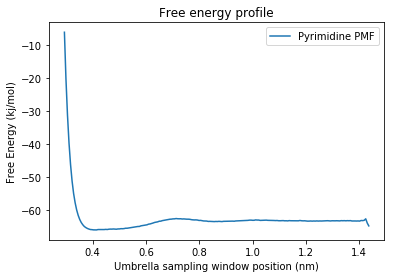

In [42]:
x, y = [], []

with open("profile.xvg") as f:
    for line in f:
        cols = line.split()
        if not line.startswith(('@', '#')):
                correctionfactor = float(2*8.314e-3*298.15*math.log(float(cols[0])))
                yvalue = float(cols[1])+correctionfactor
                x.append(float(cols[0]))
                y.append(yvalue)

plt.plot(x, y)
label = ['Pyrimidine PMF']
plt.title('Free energy profile')    

plt.xlabel('Umbrella sampling window position (nm)')
plt.ylabel('Free Energy (kj/mol)')
plt.legend(label);

Text(0.5,1,u'Umbrella sampling histograms')

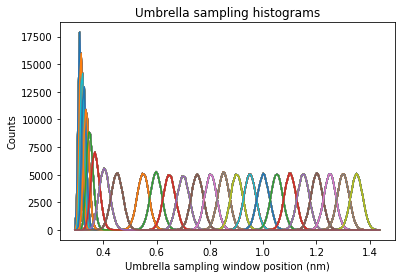

In [43]:
# Second plot for the histogram data

x, y, labels = [], [], []

with open("histo.xvg") as f:
    for line in f:
        cols = line.split()
        if not line.startswith(('@', '#')):

            colnum = len(cols)
            x.append(float(cols[0]))
            tmpy = []
            for col in range (1, colnum-1):
                tmpy.append(float(cols[col]))
            y.append(tmpy)
            labels.append('run-'+str(col))

for col in range (1, colnum-1):
    plt.plot(x, y)
    
plt.xlabel('Umbrella sampling window position (nm)')
plt.ylabel('Counts')
plt.title('Umbrella sampling histograms')    
#plt.legend(labels);


The plots can then be analysed to check for e.g. overlap between the individual windows
for the histograms, or the free energy profile can be investigated for points that might need
more sampling.

# End of the tutorial

I hope you found the tutorial at least somehow helpful, and that you will now be
able to set up and run simulations for some simple test cases yourself

startdir = globalpath
os.chdir(startdir)